<a href="https://colab.research.google.com/github/shreyanshchordia/image_auto_encoder/blob/master/simple_dense_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [0]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std= (0.5)),
    transforms.Lambda(lambda x: torch.flatten(x))
])

EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001

In [0]:
train_dataset = MNIST('./data',
                      train = True,
                      transform = img_transform,
                      download = True)

train_dataloader = DataLoader(train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = 2)

test_dataset = MNIST('./data',
                      train = False,
                      transform = img_transform,
                      download = True)

test_dataloader = DataLoader(test_dataset,
                              batch_size = BATCH_SIZE//2,
                              shuffle = True)

In [53]:
print(len(train_dataset),
      len(test_dataset))

60000 10000


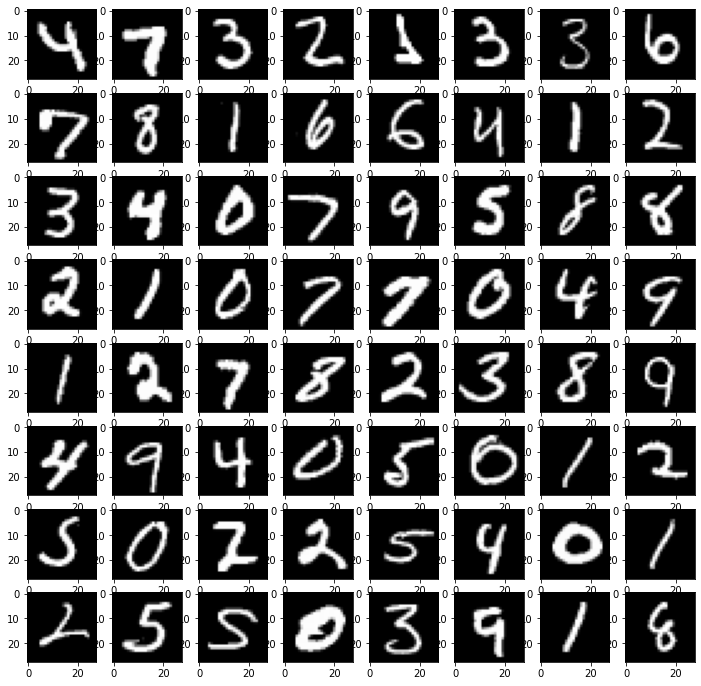

In [54]:
imgs,_ = next(iter(test_dataloader))
fig = plt.figure(figsize=(12,12))
for i,image in enumerate(imgs[:64]):

    plt.subplot(8,8,i+1)
    image = (np.asarray(image).reshape(28,28) * 0.5) + 0.5  # unflattening and rescaling
    plt.imshow(image, cmap = 'gray')

plt.show()

In [0]:
class AutoEncoder(nn.Module):

    def __init__(self):
        
        super(AutoEncoder,self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(in_features= 784,out_features= 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.2),

            nn.Linear(in_features=128, out_features = 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.2),

            nn.Linear(in_features=64, out_features = 16),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.1)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=16, out_features = 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.1),

            nn.Linear(in_features= 64,out_features= 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.2),

            nn.Linear(in_features=128, out_features = 784),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.2)
        )
    
    def forward(self, x):

        encoded = self.encoder(x)

        x = self.decoder(encoded)

        return x
    
    def get_encodings(self, x):

        encoded = self.encoder(x)

        return encoded


In [0]:
model = AutoEncoder().cuda()
cost = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=1e-5)

In [0]:
def to_img(x):
    x = (0.5 * x) + 0.5
    return (x.view(x.shape[0],1,28,28))

In [0]:
def train_model(model,dataloader,num_epochs,cost,optimizer):

    loss_values = []

    for epoch in range(1,num_epochs+1):

        for data in dataloader:
            img, _ = data
            img = Variable(img).cuda()

            # =================== forward =====================
            output = model(img)
            loss = cost(output, img)
            # =================== backward ====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # =================== log ========================


        print('epoch [{}/{}], loss:{:.4f}'.format(epoch, 
                                                 num_epochs, 
                                                  loss.data))
        loss_values.append(loss.data)

        pic = to_img(output.cpu().data)
        save_image(pic, './ae_img/image_{}.png'.format(epoch))
        
    return loss_values


In [65]:
loss_history = train_model(model,train_dataloader,EPOCHS,cost,optimizer)

epoch [1/20], loss:0.4056
epoch [2/20], loss:0.3860
epoch [3/20], loss:0.3928
epoch [4/20], loss:0.3869
epoch [5/20], loss:0.3821
epoch [6/20], loss:0.3801
epoch [7/20], loss:0.3712
epoch [8/20], loss:0.3729
epoch [9/20], loss:0.3732
epoch [10/20], loss:0.3690
epoch [11/20], loss:0.3651
epoch [12/20], loss:0.3561
epoch [13/20], loss:0.3686
epoch [14/20], loss:0.3554
epoch [15/20], loss:0.3545
epoch [16/20], loss:0.3533
epoch [17/20], loss:0.3646
epoch [18/20], loss:0.3682
epoch [19/20], loss:0.3663
epoch [20/20], loss:0.3686


In [69]:
print(loss_history)

[tensor(0.4056, device='cuda:0'), tensor(0.3860, device='cuda:0'), tensor(0.3928, device='cuda:0'), tensor(0.3869, device='cuda:0'), tensor(0.3821, device='cuda:0'), tensor(0.3801, device='cuda:0'), tensor(0.3712, device='cuda:0'), tensor(0.3729, device='cuda:0'), tensor(0.3732, device='cuda:0'), tensor(0.3690, device='cuda:0'), tensor(0.3651, device='cuda:0'), tensor(0.3561, device='cuda:0'), tensor(0.3686, device='cuda:0'), tensor(0.3554, device='cuda:0'), tensor(0.3545, device='cuda:0'), tensor(0.3533, device='cuda:0'), tensor(0.3646, device='cuda:0'), tensor(0.3682, device='cuda:0'), tensor(0.3663, device='cuda:0'), tensor(0.3686, device='cuda:0')]


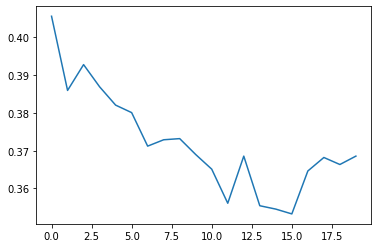

In [70]:
history = np.asarray(loss_history)
plt.plot(history)
plt.show()

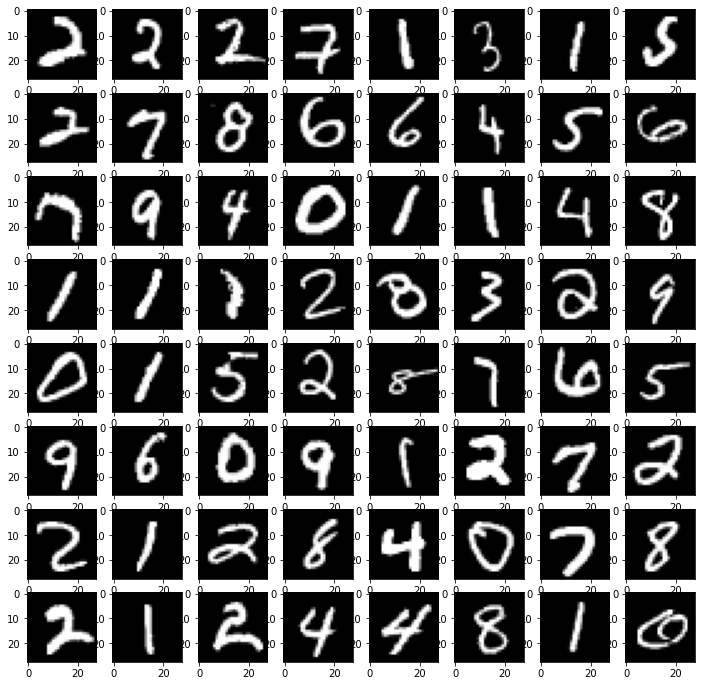

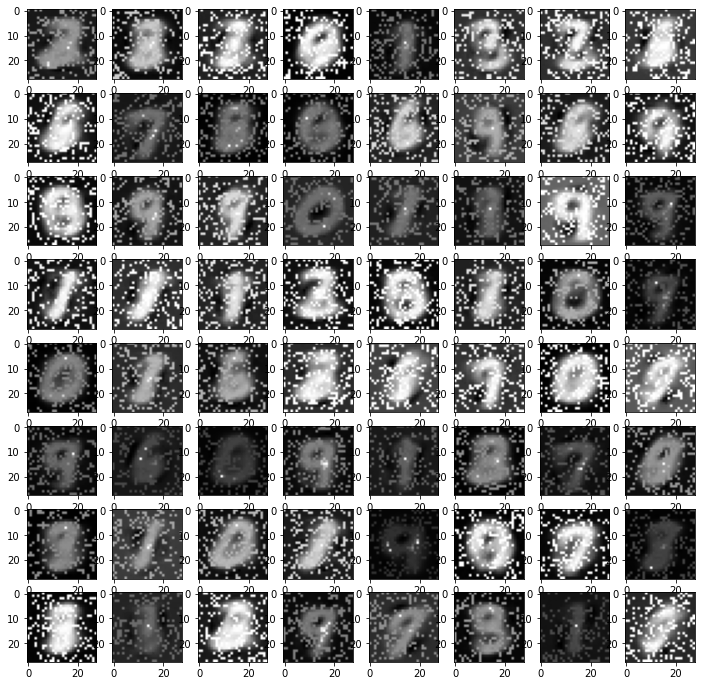

In [71]:
imgs,_ = next(iter(test_dataloader))
fig = plt.figure(figsize=(12,12))
x = imgs[:64]

for i,image in enumerate(x):

    plt.subplot(8,8,i+1)
    image = (np.asarray(image).reshape(28,28) * 0.5) + 0.5  # unflattening and rescaling
    plt.imshow(image, cmap = 'gray')

plt.show()

fig = plt.figure(figsize=(12,12))
x = Variable(imgs[:64]).cuda()
x = model(x).cpu().detach().numpy()
for i,image in enumerate(x):
    plt.subplot(8,8,i+1)
    image = (np.asarray(image).reshape(28,28) * 0.5) + 0.5  # unflattening and rescaling
    plt.imshow(image, cmap = 'gray')

plt.show()